In [44]:
import numpy as np
# import scipy.stats as ss
# from scipy.spatial import distance_matrix
import random
import pandas as pd
from sklearn.cluster import SpectralClustering,DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
from collections import defaultdict, OrderedDict
from glob import glob
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.optimize import curve_fit

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# Analysis to find the lower bound for heterozygosity

In [2]:
ddistDir="/home/brett/work/TrajectoryInference/SNPBarcodingSimulator/simulation/analysis/lower_heterozygosity_bound"

In [7]:
spectral_results,dbscan_results = {},{}
for ddistPath in glob(ddistDir+"/*_nhd.csv"):
    label = os.path.basename(ddistPath).split("_nhd.csv")[0]
    heterozygosity = label.split("_")[2].split("h")[1]
    num_snps = int(label.split("_")[3].split("snps")[0])
    trial = int(label.split("_")[5].split("trial")[1])
    with open(f"{os.path.dirname(ddistPath)}/{label}_true_clusters.txt", "r") as f:
        true_clusters = f.read().splitlines()
    true_clusters = [int(i) for i in true_clusters]
    ddistX = pd.read_csv(ddistPath, header=None).to_numpy()
    n,m = ddistX.shape
    for i in range(n):
        for j in range(m):
            if str(ddistX[i,j]) == "nan":
                ddistX[i,j] = np.inf
    
    X = np.exp(-ddistX)
    
    try:
        spectral_clusters = SpectralClustering(n_clusters=10,affinity='precomputed').fit(X)
        # dbscan_clusters = DBSCAN().fit(X)
        
        spectral_accuracy = adjusted_rand_score(true_clusters,spectral_clusters.labels_)
        # dbscan_accuracy = adjusted_rand_score(true_clusters,dbscan_clusters.labels_)

        spectral_results[(num_snps,trial)] = f"{spectral_accuracy} adjusted rand index (heterozygosity={heterozygosity})"
        # dbscan_results[(num_snps,trial)] = f"{dbscan_accuracy} adjusted rand index (heterozygosity={heterozygosity})"
        
    except Exception as e: 
        
        spectral_results[(num_snps,trial)] = f"{e} (heterozygosity={heterozygosity})"
        # dbscan_results[(num_snps,trial)] = f"{e} (heterozygosity={heterozygosity})"
        
    

ordered_spectral_results = OrderedDict(sorted(spectral_results.items()))
# for key,out in ordered_spectral_results.items():
#     print(f"{key}: {out}")
    
# ordered_dbscan_results = OrderedDict(sorted(dbscan_results.items()))
# for key,out in ordered_dbscan_results.items():
#     print(f"{key}: {out}")

/home/brett/tool/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/brett/tool/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/brett/tool/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/brett/tool/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, 

/home/brett/tool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/brett/tool/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


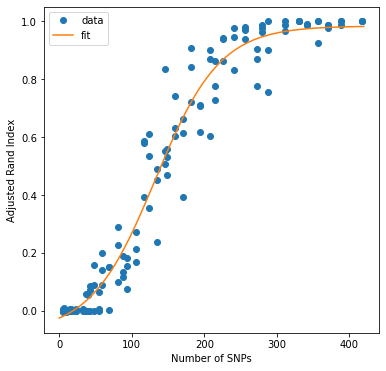

In [9]:
snps, adj_rand_index = [],[]
for key,out in ordered_spectral_results.items():
    if key == (6,1): continue
    n_snps,trial = key
    adj_rand = float(out.split(" adjusted rand index")[0])
    snps.append(n_snps)
    adj_rand_index.append(adj_rand)

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(adj_rand_index), np.median(snps),1,min(adj_rand_index)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, snps, adj_rand_index,p0, method='dogbox')

x = np.linspace(0, 420, 1000)
y = sigmoid(x, *popt)

fig,ax = plt.subplots(figsize=(6,6))
plt.plot(snps, adj_rand_index, 'o', label='data')
plt.plot(x,y, label='fit')
plt.xlabel("Number of SNPs")
plt.ylabel("Adjusted Rand Index")
plt.legend(loc='best')
plt.show()

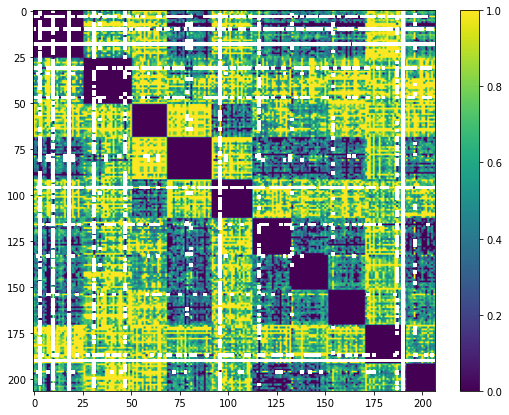

In [48]:
fig,ax = plt.subplots(figsize=(9,7))
h1 = ax.imshow(ddistX, aspect='auto')
fig.colorbar(h1, ax=ax)
plt.show()

# Analysis looking at the number of embryos and clustering accuracy

In [10]:
ddistDir="/home/brett/work/TrajectoryInference/SNPBarcodingSimulator/simulation/analysis/num_embryo_analysis"

In [11]:
spectral_results,dbscan_results,xmeans_results = {},{},{}
for ddistPath in tqdm(glob(ddistDir+"/*_nhd.csv")):
    label = os.path.basename(ddistPath).split("_nhd.csv")[0].split("_")
    num_embryos = int(label[1].split("embryos")[0])
    heterozygosity = label[2].split("h")[1]
    num_snps = int(label[3].split("snps")[0])
    trial = int(label[5].split("trial")[1])

    with open(f"{os.path.dirname(ddistPath)}/{'_'.join(label)}_true_clusters.txt", "r") as f:
        true_clusters = f.read().splitlines()
    true_clusters = [int(i) for i in true_clusters]
    ddistX = pd.read_csv(ddistPath, header=None).to_numpy()
    n,m = ddistX.shape
    for i in range(n):
        for j in range(m):
            if str(ddistX[i,j]) == "nan":
                ddistX[i,j] = np.inf
    
    X = np.exp(-ddistX)
    
    try:
        
        spectral_clusters = SpectralClustering(n_clusters=num_embryos,affinity='precomputed').fit(X)        
        spectral_accuracy = adjusted_rand_score(true_clusters,spectral_clusters.labels_)
        spectral_results[(num_embryos,trial)] = f"{spectral_accuracy} adjusted rand index (heterozygosity={heterozygosity})"
        
        dbscan_clusters = DBSCAN().fit(X)        
        dbscan_accuracy = adjusted_rand_score(true_clusters,dbscan_clusters.labels_)
        dbscan_results[(num_embryos,trial)] = f"{dbscan_accuracy} adjusted rand index (heterozygosity={heterozygosity})"
        
        nInitialCenters, maxNumClusters = 2, 1000
        initialCenters = kmeans_plusplus_initializer(X, nInitialCenters).initialize()
        xmeans_instance = xmeans(X, initialCenters, maxNumClusters).process()
        xmeans_clusters = []
        for i in range(X.shape[0]):
            for cluster_id,cluster in enumerate(xmeans_instance.get_clusters()):
                if i in cluster:
                    xmeans_clusters.append(cluster_id)
        xmeans_accuracy = adjusted_rand_score(true_clusters,xmeans_clusters)
        xmeans_results[(num_embryos,trial)] = f"{xmeans_accuracy} adjusted rand index (heterozygosity={heterozygosity})"
        
    except Exception as e: 
        
        spectral_results[(num_embryos,trial)] = f"{e} (heterozygosity={heterozygosity})"
        
        dbscan_results[(num_embryos,trial)] = f"{e} (heterozygosity={heterozygosity})"
        
        xmeans_results[(num_embryos,trial)] = f"{e} (heterozygosity={heterozygosity})"


100%|██████████████████████████████████████████████████| 150/150 [06:05<00:00,  2.43s/it]


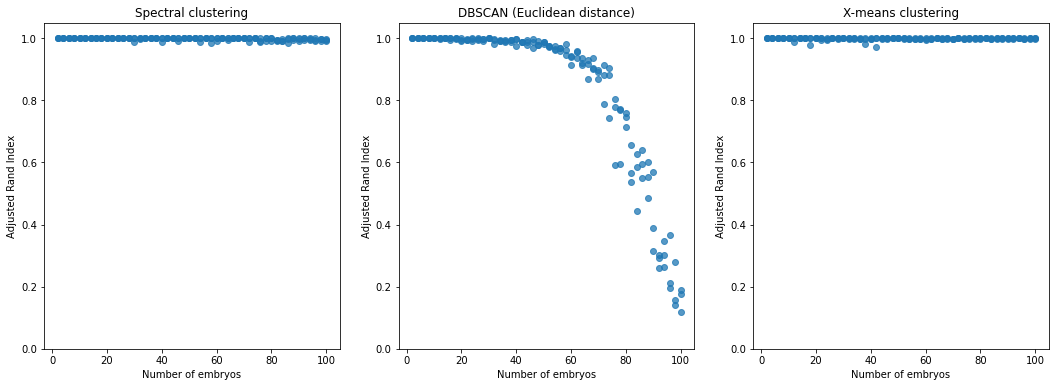

In [12]:
ordered_spectral_results = OrderedDict(sorted(spectral_results.items()))  
ordered_dbscan_results = OrderedDict(sorted(dbscan_results.items()))
ordered_xmeans_results = OrderedDict(sorted(xmeans_results.items()))

spectral_n_embryos, spectral_adj_rand_index = [],[]
for key,out in ordered_spectral_results.items():
    n,trial = key
    adj_rand = float(out.split(" adjusted rand index")[0])
    spectral_n_embryos.append(n)
    spectral_adj_rand_index.append(adj_rand)

dbscan_n_embryos, dbscan_adj_rand_index = [],[]
for key,out in ordered_dbscan_results.items():
    n,trial = key
    adj_rand = float(out.split(" adjusted rand index")[0])
    dbscan_n_embryos.append(n)
    dbscan_adj_rand_index.append(adj_rand)

xmeans_n_embryos, xmeans_adj_rand_index = [],[]
for key,out in ordered_xmeans_results.items():
    n,trial = key
    adj_rand = float(out.split(" adjusted rand index")[0])
    xmeans_n_embryos.append(n)
    xmeans_adj_rand_index.append(adj_rand)
    
fig,ax = plt.subplots(1,3, figsize=(18,6))  

ax[0].plot(spectral_n_embryos, spectral_adj_rand_index, 'o', alpha=0.75)
ax[0].set_ylim(0,1.05)
ax[0].set(xlabel="Number of embryos", ylabel="Adjusted Rand Index")
ax[0].set_title("Spectral clustering")

ax[1].plot(dbscan_n_embryos, dbscan_adj_rand_index, 'o', alpha=0.75)
ax[1].set_ylim(0,1.05)
ax[1].set(xlabel="Number of embryos", ylabel="Adjusted Rand Index")
ax[1].set_title("DBSCAN (Euclidean distance)")

ax[2].plot(xmeans_n_embryos, xmeans_adj_rand_index, 'o', alpha=0.75)
ax[2].set_ylim(0,1.05)
ax[2].set(xlabel="Number of embryos", ylabel="Adjusted Rand Index")
ax[2].set_title("X-means clustering")

plt.show()

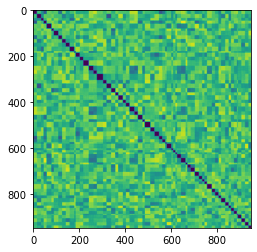

In [47]:
plt.imshow(ddistX)
plt.show()

# Visualizing dropout data

In [13]:
countsPath="/home/brett/work/TrajectoryInference/SNPBarcodingSimulator/input/LV_counts_10hpf.csv"

In [14]:
count_df = pd.read_csv(countsPath)
count_df = count_df[count_df["Lv_name"] != "LVA_m28240.t1"]
print(count_df.head())

        Lv_name                       Name  AAACCCAGTAGAGACC.1  \
0      LVA_1.t1          LVA_1.t1:Sp-Unk_5                   1   
1     LVA_10.t1             LVA_10.t1:none                   0   
2   LVA_1000.t1     LVA_1000.t1:Sp-Kctd1_2                   0   
3  LVA_10002.t1  LVA_10002.t1:Sp-PolppL_64                   0   
4  LVA_10004.t1  LVA_10004.t1:Sp-Hypp_2701                   0   

   AAACCCAGTGAGAACC.1  AAACCCAGTGCCTGCA.1  AAACCCAGTGCTGTCG.1  \
0                   1                   1                   1   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   AAACCCAGTTTCGTGA.1  AAACCCATCTGCCCTA.1  AAACGAAAGATCGGTG.1  \
0                   3                   1                   1   
1                   0                   0                   0   
2                

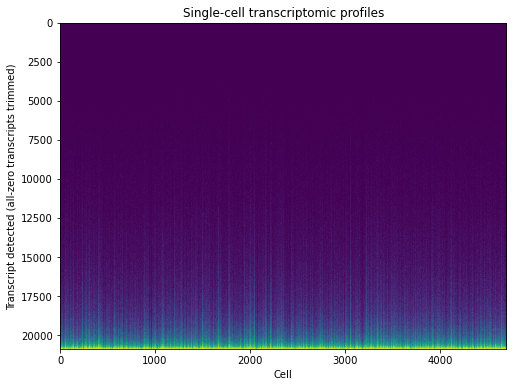

In [68]:
# gene_names = list(count_df["Lv_name"])
counts = count_df.iloc[:,2:]
# counts.index = gene_names
counts = counts.to_numpy()
counts = np.array(sorted(counts, key=sum))

n,m = counts.shape
dropout = np.zeros((n,m), dtype=np.uint8)
for i in range(n):
    for j in range(m):
        if counts[i,j] > 0:
            dropout[i,j] = 1
            
dropout_trimmed = dropout[~np.all(dropout == 0, axis=1)]

fig,ax = plt.subplots(figsize=(8,6))
h1 = ax.imshow(dropout_trimmed, aspect='auto')
plt.title("Single-cell transcriptomic profiles")
plt.xlabel("Cell")
plt.ylabel("Transcript detected (all-zero transcripts trimmed)")
plt.show()

In [1]:
# print(dropout.shape)
# row_sum = np.sum(dropout, axis=1)
# print(len(row_sum))
# num_zeros = 0
# for i in row_sum:
#     if i == 0:
#         num_zeros += 1
# print(num_zeros)

# dropout_trimmed = dropout[~np.all(dropout == 0, axis=1)]
# print(np.min(dropout_trimmed), np.max(dropout_trimmed))